# Imports

In [ ]:
source_data["train"]["x"].shape

(99200, 200)

In [ ]:
s = 0
for k in source_data:
    s += source_data[k]["x"].shape[0]
s

124000

In [ ]:
s = 0
for k in target_data:
    s += target_data[k]["x"].shape[0]
s

64000

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shutil
import tensorflow as tf
import warnings

from copy import deepcopy
from google.colab import drive
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from tabulate import tabulate

In [ ]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pylab
import random
import tensorflow as tf
import wave

from pathlib import Path
from PIL import Image
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Supress Warnings

In [ ]:
# Supress warnings
warnings.resetwarnings()
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

# Global Variables

In [ ]:
dataset_dir = "/content/drive/MyDrive/Classes/CSCE 6810 Advanced Topics in Computational Life Science/Group Project/Dataset/"
single_1_dir = dataset_dir + "Model Ready/Single Cell/Batched/"
single_2_dir = dataset_dir + "Preprocessed/Single Cell/intermediate_GSE132465_GEO_processed_CRC_10X_natural_log_TPM_matrix/"
multi_dir = dataset_dir + "Model Ready/Multi Cell/Batched/"

data_dir = "data/"
source_dir = data_dir + "source/"
target_dir = data_dir + "target/"

# Load Data

In [ ]:
for d in [target_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

## Multi Cell

In [ ]:
shutil.copytree(multi_dir, source_dir)

'data/source/'

In [ ]:
data = None
for i in range(1000):
    if data is None:
        data = pd.read_csv(source_dir + "batch_%d.csv"%(i))
    else:
        data = pd.concat([data, pd.read_csv(source_dir + "batch_%d.csv"%(i))])

l = data.shape[0]
split_1 = int(l*0.8)
split_2 = int((l - split_1) / 2)

source_data = {"train": None, "val": None, "test": None}
source_data["train"] = data.sample(split_1, axis=0, replace=False)
source_data["val"] = data.sample(split_2, replace=False)
source_data["test"] = data.sample((l-split_1-split_2), replace=False)

for k in ["train", "val", "test"]:
    cols = list(source_data[k].columns)
    x = source_data[k][cols[:-1]]
    y = source_data[k][cols[-1]]
    source_data[k] = {"x": x, "y": y}

## Single Cell

## Make Batch Files

In [ ]:
target_dir_len = len(os.listdir(single_1_dir))

In [ ]:
# target_dir_len = 5
c = 0
df = None
for f in os.listdir(single_2_dir):
    if c == target_dir_len:
        break
    tmp = pd.read_csv(single_2_dir + f)
    tmp = tmp.assign(label=1)
    if df is None:
        df = deepcopy(tmp)
    else:
        df = pd.concat([df, tmp], axis=0, ignore_index=True)

    while len(df) > 64:
        tmp = df.sample(64, replace=False, axis=0)
        batch = pd.read_csv(single_1_dir + "batch_%d.csv"%(c))
        batch = batch.assign(label=0)
        batch = pd.concat([batch, tmp], axis=0, ignore_index=True)
        batch = batch.sample(frac=1, random_state=42, axis=0)
        batch.to_csv(target_dir + "batch_%d.csv"%(c), index=False)
        c += 1
        print(c)

        if c == target_dir_len:
            break

## Load Into Memory

In [ ]:
data = None
for i in range(500):
    if data is None:
        data = pd.read_csv(target_dir + "batch_%d.csv"%(i))
    else:
        data = pd.concat([data, pd.read_csv(target_dir + "batch_%d.csv"%(i))])

l = len(data)
split_1 = int(l*0.8)
split_2 = int((l - split_1) / 2)

target_data = {"train": None, "val": None, "test": None}
target_data["train"] = data.sample(split_1, axis=0, replace=False)
target_data["val"] = data.sample(split_2, replace=False)
target_data["test"] = data.sample((l-split_1-split_2), replace=False)

for k in ["train", "val", "test"]:
    cols = list(target_data[k].columns)
    x = target_data[k][cols[:-1]]
    y = target_data[k][cols[-1]]
    target_data[k] = {"x": x, "y": y}

In [ ]:
len(target_data["train"]["x"])

51200

In [ ]:
len(target_data["val"]["x"])

6400

In [ ]:
len(target_data["test"]["x"])

6400

In [ ]:
del data

# Model Handler

In [ ]:
class Trainer():

    def __init__(self):
        self.name = ""

    def build_model(self, model, input_shape, n_labels, model_type):
        
        # Build dense model
        if model_type == "dense":
            model.add(tf.keras.layers.Dense(200, activation="relu"))
            model.add(tf.keras.layers.Dense(100, activation="relu"))
            model.add(tf.keras.layers.Dense(50, activation="relu"))

        model.add(tf.keras.layers.Dense(n_labels, activation="softmax"))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                           metrics=["accuracy"]
                           )

        # Compile model
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.RMSprop(),
            metrics=['accuracy'],
        )
        return model
    
    def build_source_model(self, input_shape, n_labels, model_type):
        model = tf.keras.Sequential([tf.keras.layers.Input(shape=input_shape)])
        self.model = self.build_model(model, input_shape, n_labels, model_type)

    def build_transfer_model(self, input_shape, n_labels, model_type, train_layers):
        model = tf.keras.Sequential([tf.keras.layers.Input(shape=input_shape)])

        tmp = self.build_model(model, input_shape, n_labels, model_type)

        tmp.add(tf.keras.layers.Dense(n_labels, activation="softmax"))

        for new_layer, layer in zip(tmp.layers[1:-train_layers], self.model.layers[1:-train_layers]):
            new_layer.set_weights(layer.get_weights())
            new_layer.trainable = False
            
        tmp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=["accuracy"]
                    )
        
        self.model = deepcopy(tmp)

    def train_model_dataset(self, train_x, train_y, val_x, val_y, epochs):
        self.history = self.model.fit(train_x, train_y, epochs=epochs, validation_data=(val_x, val_y))

    def test_model_dataset(self, test_x, test_y, n_labels, verbose=True):
        preds = self.model.predict(test_x)
        preds_select = np.apply_along_axis(np.argmax, 1, preds)
        true = [y for y in test_y.values]

        loss, acc = self.model.evaluate(test_x, test_y, verbose=2)
        scores = precision_recall_fscore_support(true, preds_select, average='macro')
        pre = scores[0]
        re = scores[1]
        f1 = scores[2]

        cm_labels = [x for x in range(n_labels)]
        cm = confusion_matrix(true, preds_select, labels=cm_labels)

        if verbose:
            print("\nModel Results:")
            print("Loss: %f\nAccuracy: %f\nPrecision: %f\nRecall: %f\nF1: %f"%(loss, acc, pre, re, f1))
            print("\nConfusion Matrix:")
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
            disp.plot()

        return loss, acc, pre, re, f1, preds, cm

# Training

In [ ]:
name = "dense"

source_input_shape = (200)
target_input_shape = (200)

source_classes = 31
target_classes = 2

epochs = 10
train_layers = 2

In [ ]:
# # Source
model = Trainer()
model.build_source_model(source_input_shape, source_classes, name)
model.train_model_dataset(source_data["train"]["x"], source_data["train"]["y"], source_data["val"]["x"], source_data["val"]["y"], epochs)

Epoch 1/10
3100/3100 [==============================] - 11s 3ms/step - loss: 3.4417 - accuracy: 0.0315 - val_loss: 3.4343 - val_accuracy: 0.0326
Epoch 2/10
3100/3100 [==============================] - 8s 3ms/step - loss: 3.4343 - accuracy: 0.0322 - val_loss: 3.4343 - val_accuracy: 0.0322
Epoch 3/10
3100/3100 [==============================] - 8s 3ms/step - loss: 3.4343 - accuracy: 0.0323 - val_loss: 3.4342 - val_accuracy: 0.0315
Epoch 4/10
3100/3100 [==============================] - 9s 3ms/step - loss: 3.4343 - accuracy: 0.0312 - val_loss: 3.4342 - val_accuracy: 0.0316
Epoch 5/10
3100/3100 [==============================] - 8s 3ms/step - loss: 3.4343 - accuracy: 0.0307 - val_loss: 3.4345 - val_accuracy: 0.0300
Epoch 6/10
3100/3100 [==============================] - 8s 3ms/step - loss: 3.4343 - accuracy: 0.0326 - val_loss: 3.4341 - val_accuracy: 0.0333
Epoch 7/10
3100/3100 [==============================] - 8s 3ms/step - loss: 3.4343 - accuracy: 0.0317 - val_loss: 3.4342 - val_accuracy

388/388 [==============================] - 1s 1ms/step
388/388 - 1s - loss: 3.4342 - accuracy: 0.0307 - 580ms/epoch - 1ms/step

Model Results:
Loss: 3.434153
Accuracy: 0.030726
Precision: 0.000991
Recall: 0.032258
F1: 0.001923

Confusion Matrix:


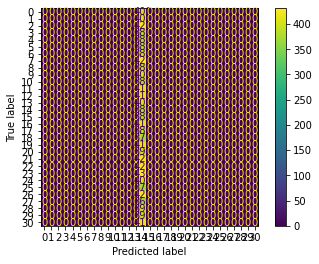

In [ ]:
_ = model.test_model_dataset(source_data["test"]["x"], source_data["test"]["y"], source_classes)

In [ ]:
# Target
model.build_transfer_model(target_input_shape, target_classes, name, train_layers)
model.train_model_dataset(target_data["train"]["x"], target_data["train"]["y"], target_data["val"]["x"], target_data["val"]["y"], epochs)

Epoch 1/10
1600/1600 [==============================] - 7s 4ms/step - loss: 0.3745 - accuracy: 0.5548 - val_loss: 0.1951 - val_accuracy: 0.5306
Epoch 2/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.2688 - accuracy: 0.5506 - val_loss: 0.1199 - val_accuracy: 0.5156
Epoch 3/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1319 - accuracy: 0.5151 - val_loss: 0.0602 - val_accuracy: 0.5089
Epoch 4/10
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0971 - accuracy: 0.5097 - val_loss: 0.0432 - val_accuracy: 0.5036
Epoch 5/10
1600/1600 [==============================] - 4s 3ms/step - loss: 0.0795 - accuracy: 0.5085 - val_loss: 0.0203 - val_accuracy: 0.5030
Epoch 6/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0667 - accuracy: 0.5062 - val_loss: 0.0188 - val_accuracy: 0.5000
Epoch 7/10
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0555 - accuracy: 0.5042 - val_loss: 0.0086 - val_accuracy:

200/200 [==============================] - 0s 1ms/step
200/200 - 0s - loss: 0.0659 - accuracy: 0.4716 - 294ms/epoch - 1ms/step

Model Results:
Loss: 0.065908
Accuracy: 0.471563
Precision: 0.979746
Recall: 0.978288
F1: 0.978567

Confusion Matrix:


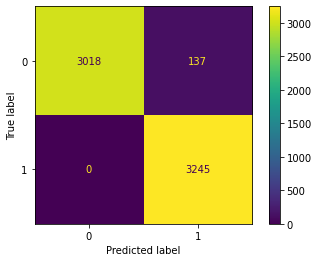

In [ ]:
_ = model.test_model_dataset(target_data["test"]["x"], target_data["test"]["y"], target_classes)

In [ ]:
# Baseline
model = Trainer()
model.build_source_model(target_input_shape, target_classes, name)
model.train_model_dataset(target_data["train"]["x"], target_data["train"]["y"], target_data["val"]["x"], target_data["val"]["y"], epochs*2)

Epoch 1/20
1600/1600 [==============================] - 5s 3ms/step - loss: 0.4187 - accuracy: 0.8417 - val_loss: 0.5293 - val_accuracy: 0.6677
Epoch 2/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.3704 - accuracy: 0.8955 - val_loss: 0.7572 - val_accuracy: 0.8306
Epoch 3/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.3106 - accuracy: 0.9382 - val_loss: 0.0915 - val_accuracy: 0.9639
Epoch 4/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.2507 - accuracy: 0.9612 - val_loss: 0.1061 - val_accuracy: 0.9603
Epoch 5/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.3594 - accuracy: 0.9729 - val_loss: 6.7867e-04 - val_accuracy: 1.0000
Epoch 6/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.3650 - accuracy: 0.9698 - val_loss: 0.0098 - val_accuracy: 0.9962
Epoch 7/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.3685 - accuracy: 0.9760 - val_loss: 0.0544 - val_accur

200/200 [==============================] - 0s 1ms/step
200/200 - 0s - loss: 0.0022 - accuracy: 0.9998 - 287ms/epoch - 1ms/step

Model Results:
Loss: 0.002211
Accuracy: 0.999844
Precision: 0.999846
Recall: 0.999842
F1: 0.999844

Confusion Matrix:


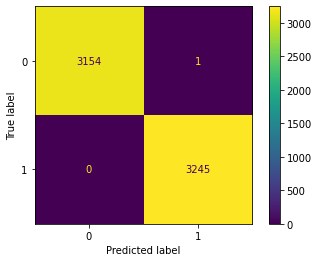

In [ ]:
_ = model.test_model_dataset(target_data["test"]["x"], target_data["test"]["y"], target_classes)

# Bottom